<a href="https://colab.research.google.com/github/businsweetie/deep_learning/blob/main/Task_4_3_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт бибилиотек и функции

In [ ]:
# импорт нужных бибилиотек
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

from skimage import exposure

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import Xception

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

## Загрузка набора данных

In [ ]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Dec 18 11:30 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

100% 2.36G/2.37G [00:32<00:00, 136MB/s]
100% 2.37G/2.37G [00:32<00:00, 79.1MB/s]


# Чтение данных

In [ ]:
# разархивирование данных
!unzip "/content/weed-detection-in-soybean-crops.zip" -d "/content/weed_detection"

In [ ]:
labels = ["soil", "grass"]
IMG_SIZE = 224

In [ ]:
X  =[]
Y = []
image_size = (IMG_SIZE, IMG_SIZE)

for i in labels:
    Datasetspath = "/content/weed_detection/dataset/dataset/" + i + "/"
    print(Datasetspath)
    fileRead = glob.glob(Datasetspath + "*")
    print(len(fileRead))

    for file in fileRead:
        image = cv2.imread(file)
        img = cv2.resize(image, image_size)
        X.append(img)
        Y.append(i)
X = np.array(X)
Y = np.array(Y)

/content/weed_detection/dataset/dataset/soil/
3249
/content/weed_detection/dataset/dataset/grass/
3520


# Исследование данных

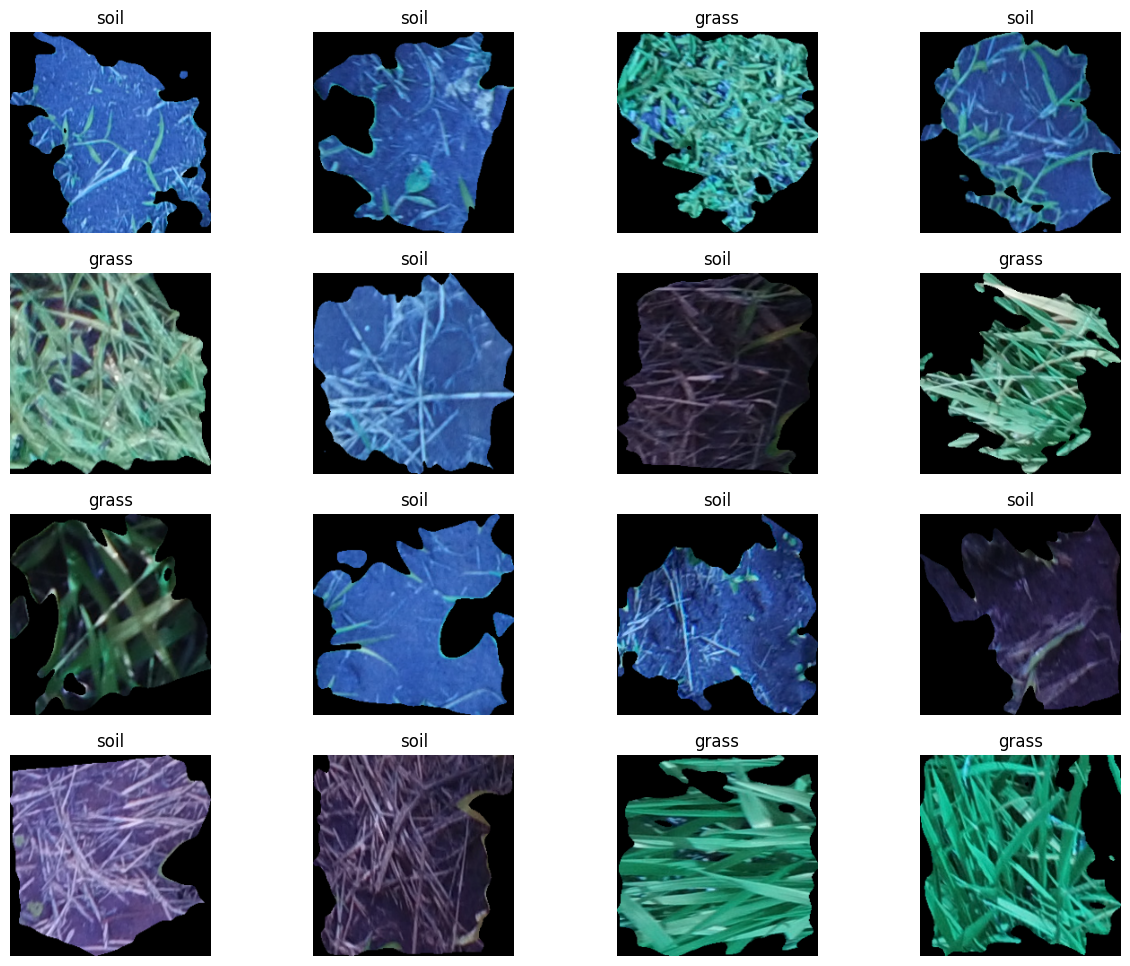

In [ ]:
plt.figure(figsize=(15, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    random_index = random.randint(0, len(X) - 1)
    plt.imshow(X[random_index])
    plt.title(Y[random_index])
    plt.axis('off')

In [ ]:
# конвертируем названия классов в метки
lb = LabelEncoder()
y = lb.fit_transform(Y)
class_names = lb.classes_
class_names

array(['grass', 'soil'], dtype='<U5')

# Деление на выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 4332
Размер валидационной выборки: 1083
Размер тестовой выборки: 1354


In [ ]:
classes = np.unique(y_train)
mapping = dict(zip(classes, class_names))

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Обучение модели

In [ ]:
pre_model = Xception(weights='imagenet',
                  include_top = False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
pre_model.trainable=True

In [ ]:
x = pre_model.output
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(2, activation='softmax')(x)
model = Model(pre_model.input, output)
#model.summary()

In [ ]:
model.compile(Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, mode = 'min',
                    restore_best_weights = True, verbose = 1)

In [ ]:
history = model.fit(
      X_train,
      y_train,
      epochs=1,
      batch_size=32,
      validation_data=(X_val, y_val),
      verbose=1)

136/136 [==============================] - 4106s 30s/step - loss: 0.0512 - accuracy: 0.9822 - val_loss: 0.0646 - val_accuracy: 0.9908


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/DL/image_classificaion.h5")

In [ ]:
def grad_cam(input_image, model, layer_name):

    desired_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [desired_layer.output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(input_image)
        ix = (np.argsort(preds, axis=1)[:, -1]).item()
        output_idx = preds[:, ix]

    gradient = tape.gradient(output_idx, layer_output)
    alpha_kc = np.mean(gradient, axis=(0,1,2))
    L_gradCam = tf.nn.relu(np.dot(layer_output, alpha_kc)[0])
    L_gradCam = (L_gradCam - np.min(L_gradCam)) / (np.max(L_gradCam) - np.min(L_gradCam))
    return L_gradCam.numpy()

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
def blend(img_path, gradCam_img, alpha, colormap = cv2.COLORMAP_JET):
    origin_img = img_to_array(load_img(img_path))
    gradCam_resized = cv2.resize(gradCam_img, (origin_img.shape[1], origin_img.shape[0]), interpolation = cv2.INTER_LINEAR)
    heatmap  = cv2.applyColorMap(np.uint8(gradCam_resized*255), colormap)
    superimposed_image = cv2.cvtColor(origin_img.astype('uint8'), cv2.COLOR_RGB2BGR) + heatmap * alpha
    return heatmap, superimposed_image

In [ ]:
def load_process(img, img_size):
    img = load_img(img, target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_image(img)
    return img

In [ ]:
def plot_results(model, image_path, classes):
    fig, axs = plt.subplots(figsize=(5, 5))
    layer_name = 'block14_sepconv2_act'

    img = load_process(image_path, IMG_SIZE)
    pred = model.predict(img)
    grad_cam_img = grad_cam(img, model, layer_name)
    heatmap_img, result_img = blend(image_path, grad_cam_img, 0.5)
    axs.imshow(result_img[:,:,::-1]/255)

In [ ]:
def preprocess_image(img):
    equ_img = exposure.equalize_hist(img)
    return equ_img

1/1 [==============================] - 0s 420ms/step


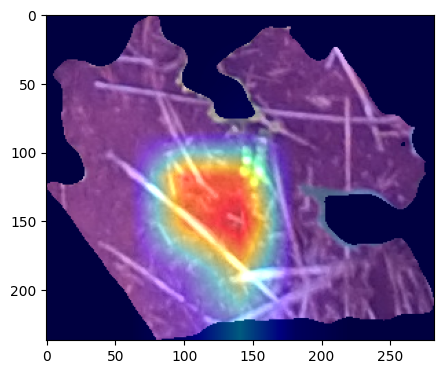

In [ ]:
plot_results(model, "/content/weed_detection/dataset/dataset/soil/1.tif", classes)

1/1 [==============================] - 1s 859ms/step


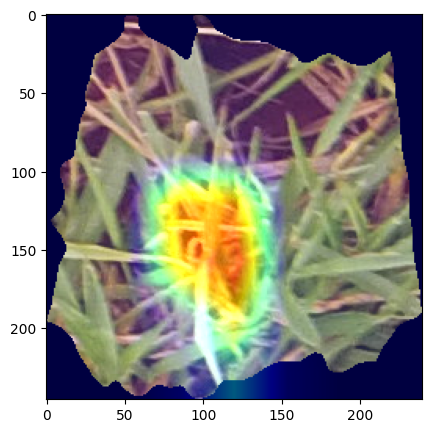

In [ ]:
plot_results(model, "/content/weed_detection/dataset/dataset/grass/1003.tif", classes)